https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [33]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

In [34]:
import os

import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [35]:
plt.style.use('ggplot')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [36]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [37]:
# model_name = "TheBloke/phi-2-GPTQ"
model_name = "microsoft/phi-2"

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [38]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


In [39]:
def reset_model(base_model):
    # peft_config = LoraConfig(
    #     # task_type=TaskType.TOKEN_CLS, 
    #     target_modules=[ "fc2",  "Wqkv",],
    #     inference_mode=False, r=4, lora_alpha=4, 
    #     # lora_dropout=0.1, 
    #     # bias="all"
    # )
    peft_config = IA3Config(
        target_modules=[ "fc2",  "Wqkv",], 
            feedforward_modules=["fc2"],
            inference_mode=False,
    )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [40]:

MAX_LEN = 400

import frontmatter
from pathlib import Path
sample_files = sorted(Path("../samples/").glob('*.md'))
print(sample_files)
samples = [{'f':f, **frontmatter.load(f).to_dict()} for f in sample_files]

for sample in samples:
    assert 'title' in sample, sample['f']
    assert 'content' in sample
samples[0].keys()

[PosixPath('../samples/bletchley_decleration.md'), PosixPath('../samples/cicero_fin1.md'), PosixPath('../samples/disney_appointment.md'), PosixPath('../samples/fake_paper.md'), PosixPath('../samples/fauci_emails.md'), PosixPath('../samples/harvard_announcement_reminders.md'), PosixPath('../samples/how_to_catch_a_liar.md'), PosixPath('../samples/lk-99_end.md'), PosixPath('../samples/lk-99_espanol.md'), PosixPath('../samples/lorem_ipsum.md'), PosixPath('../samples/openai_board_ann.md'), PosixPath('../samples/openai_paper_weak_to_strong.md'), PosixPath('../samples/politics_is_the_mind_killer.md'), PosixPath('../samples/statement_vyKamala_on_passing_of_johnson.md'), PosixPath('../samples/survey_of_rumours.md')]


dict_keys(['f', 'title', 'url', 'content'])

## Helpers

In [41]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss


def perplexity_compute(
    data, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):
    model = model.to(device)


    max_tokenized_len = max_length

    encodings = tokenizer(
        data,
        add_special_tokens=False,
        padding=True,
        truncation=True if max_tokenized_len else False,
        max_length=max_tokenized_len,
        return_tensors="pt",
        return_attention_mask=True,
    ).to(device)

    encoded_texts = encodings["input_ids"]
    attn_masks = encodings["attention_mask"]

    # check that each input is long enough:
    if add_start_token:
        assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
    else:
        assert torch.all(
            torch.ge(attn_masks.sum(1), 2)
        ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")

    for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
        end_index = min(start_index + batch_size, len(encoded_texts))
        encoded_batch = encoded_texts[start_index:end_index]
        attn_mask = attn_masks[start_index:end_index]

        labels = encoded_batch

        with torch.no_grad():
            out_logits = model(encoded_batch, attention_mask=attn_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

## Training

In [42]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Lightning helpers

In [43]:
def eval(model, tokenizer, second_half):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [44]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [45]:

def tokenize_and_split(examples):
    result = tokenizer(
        examples,
        truncation=True,
        max_length=MAX_LEN,
        return_overflowing_tokens=True,
    )
    return result

# s = sample['content']
# first_half = s[:len(s)//2]
# second_half = s[len(s)//2:]
# ds_train = Dataset.from_dict(tokenize_and_split([first_half]))
# ds_val = Dataset.from_dict(tokenize_and_split([second_half]))
# ds_train

In [46]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 1
    verbose = False

    s = sample['content']
    first_half = s[:len(s)//2]
    second_half = s[len(s)//2:]

    # TODO, I guess we need to window this
    ds_train = Dataset.from_dict(tokenize_and_split([first_half]))
    ds_val = Dataset.from_dict(tokenize_and_split([second_half]))

    os.environ['CUDA_VISIBLE_DEVICES']="1"
    model = reset_model(base_model)
    eval(model, tokenizer, second_half)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=3,
            warmup_steps=6,
            max_steps=20,
            learning_rate=3e-3,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, first_half).items()}
    result = eval(model, tokenizer, second_half)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


In [47]:
data = []
for sample in samples:
    r = learn_sample(sample)
    print(sample['title'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8731, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.934140205383301, 'eval_runtime': 1.8507, 'eval_samples_per_second': 1.081, 'eval_steps_per_second': 0.54, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8722, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.930333375930786, 'eval_runtime': 1.8509, 'eval_samples_per_second': 1.081, 'eval_steps_per_second': 0.54, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8639, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9261159896850586, 'eval_runtime': 1.852, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8556, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.921092987060547, 'eval_runtime': 1.8512, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.84, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9118905067443848, 'eval_runtime': 1.8512, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8213, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9033427238464355, 'eval_runtime': 1.8515, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7984, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8970065116882324, 'eval_runtime': 1.8538, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7788, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8897409439086914, 'eval_runtime': 1.8523, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.752, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.888181209564209, 'eval_runtime': 1.8519, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7382, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.890364408493042, 'eval_runtime': 1.8521, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7212, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8928794860839844, 'eval_runtime': 1.8515, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7034, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8941824436187744, 'eval_runtime': 1.8532, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.692, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.896975517272949, 'eval_runtime': 1.8526, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6729, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.899407386779785, 'eval_runtime': 1.8615, 'eval_samples_per_second': 1.074, 'eval_steps_per_second': 0.537, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6678, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.898254871368408, 'eval_runtime': 1.8542, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6561, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.899857521057129, 'eval_runtime': 1.8522, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6448, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9020445346832275, 'eval_runtime': 1.8524, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6436, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9011523723602295, 'eval_runtime': 1.8527, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6423, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9012508392333984, 'eval_runtime': 1.8541, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6364, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.901865005493164, 'eval_runtime': 1.853, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 20.0}
{'train_runtime': 110.4196, 'train_samples_per_second': 1.087, 'train_steps_per_second': 0.181, 'train_loss': 0.7436936140060425, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


blechley declaration
{'before': 15.099042892456055, 'after': 14.732343673706055}


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5636, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 4.2795186042785645, 'eval_runtime': 2.1952, 'eval_samples_per_second': 2.733, 'eval_steps_per_second': 0.456, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5644, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.2700276374816895, 'eval_runtime': 2.2003, 'eval_samples_per_second': 2.727, 'eval_steps_per_second': 0.454, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.57, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.258336544036865, 'eval_runtime': 2.1983, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5474, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.244501113891602, 'eval_runtime': 2.1998, 'eval_samples_per_second': 2.728, 'eval_steps_per_second': 0.455, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.4968, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.230161666870117, 'eval_runtime': 2.1985, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.4635, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.221675395965576, 'eval_runtime': 2.198, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.4153, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.215108871459961, 'eval_runtime': 2.1948, 'eval_samples_per_second': 2.734, 'eval_steps_per_second': 0.456, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.36, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.209522247314453, 'eval_runtime': 2.1924, 'eval_samples_per_second': 2.737, 'eval_steps_per_second': 0.456, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.3225, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.2080464363098145, 'eval_runtime': 2.192, 'eval_samples_per_second': 2.737, 'eval_steps_per_second': 0.456, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2847, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.206252574920654, 'eval_runtime': 2.1916, 'eval_samples_per_second': 2.738, 'eval_steps_per_second': 0.456, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2253, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205601215362549, 'eval_runtime': 2.1978, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2147, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205047130584717, 'eval_runtime': 2.1965, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1814, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.206936359405518, 'eval_runtime': 2.1952, 'eval_samples_per_second': 2.733, 'eval_steps_per_second': 0.456, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1625, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.206596851348877, 'eval_runtime': 2.1968, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1308, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205368518829346, 'eval_runtime': 2.1979, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1072, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205146789550781, 'eval_runtime': 2.1976, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.0948, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.203622817993164, 'eval_runtime': 2.197, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.0732, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.204572677612305, 'eval_runtime': 2.1979, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.0751, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205753803253174, 'eval_runtime': 2.1966, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.06, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.205715179443359, 'eval_runtime': 2.1947, 'eval_samples_per_second': 2.734, 'eval_steps_per_second': 0.456, 'epoch': 20.0}
{'train_runtime': 261.4768, 'train_samples_per_second': 0.459, 'train_steps_per_second': 0.076, 'train_loss': 4.29565052986145, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


ibois, Philippe (2012-06-03).
{'before': 61.07478713989258, 'after': 59.88446807861328}


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6237, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.759657382965088, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.621, 'learning_rate': 0.001, 'epoch': 2.0}
{'eval_loss': 2.7597293853759766, 'eval_runtime': 1.8541, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6206, 'learning_rate': 0.0015, 'epoch': 3.0}
{'eval_loss': 2.7564902305603027, 'eval_runtime': 1.853, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5974, 'learning_rate': 0.002, 'epoch': 4.0}
{'eval_loss': 2.752861976623535, 'eval_runtime': 1.8565, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.539, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5802, 'learning_rate': 0.0025, 'epoch': 5.0}
{'eval_loss': 2.748295307159424, 'eval_runtime': 1.8529, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5569, 'learning_rate': 0.003, 'epoch': 6.0}
{'eval_loss': 2.7460708618164062, 'eval_runtime': 1.8524, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5307, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}
{'eval_loss': 2.738633632659912, 'eval_runtime': 1.8539, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.504, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}
{'eval_loss': 2.734565019607544, 'eval_runtime': 1.8537, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4754, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}
{'eval_loss': 2.733013153076172, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4581, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}
{'eval_loss': 2.731515645980835, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4333, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}
{'eval_loss': 2.7264902591705322, 'eval_runtime': 1.8544, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4228, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}
{'eval_loss': 2.7332866191864014, 'eval_runtime': 1.855, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4027, 'learning_rate': 0.0015, 'epoch': 13.0}
{'eval_loss': 2.729839324951172, 'eval_runtime': 1.855, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3891, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}
{'eval_loss': 2.731370687484741, 'eval_runtime': 1.8598, 'eval_samples_per_second': 1.075, 'eval_steps_per_second': 0.538, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3841, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}
{'eval_loss': 2.732412338256836, 'eval_runtime': 1.8545, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3689, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}
{'eval_loss': 2.7393574714660645, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3563, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}
{'eval_loss': 2.7468791007995605, 'eval_runtime': 1.8542, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3526, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}
{'eval_loss': 2.7505300045013428, 'eval_runtime': 1.8532, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3435, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}
{'eval_loss': 2.757460594177246, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3398, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.760329246520996, 'eval_runtime': 1.8558, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 20.0}
{'train_runtime': 42.5025, 'train_samples_per_second': 2.823, 'train_steps_per_second': 0.471, 'train_loss': 0.4680565565824509, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


disney appointment
{'before': 7.112776756286621, 'after': 6.932384490966797}


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6745, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 1.5698368549346924, 'eval_runtime': 0.1186, 'eval_samples_per_second': 8.435, 'eval_steps_per_second': 8.435, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6751, 'learning_rate': 0.001, 'epoch': 2.0}
{'eval_loss': 1.5680769681930542, 'eval_runtime': 0.1122, 'eval_samples_per_second': 8.911, 'eval_steps_per_second': 8.911, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6686, 'learning_rate': 0.0015, 'epoch': 3.0}
{'eval_loss': 1.5664819478988647, 'eval_runtime': 0.1151, 'eval_samples_per_second': 8.685, 'eval_steps_per_second': 8.685, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6542, 'learning_rate': 0.002, 'epoch': 4.0}
{'eval_loss': 1.5632203817367554, 'eval_runtime': 0.1171, 'eval_samples_per_second': 8.537, 'eval_steps_per_second': 8.537, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.63, 'learning_rate': 0.0025, 'epoch': 5.0}
{'eval_loss': 1.5577468872070312, 'eval_runtime': 0.117, 'eval_samples_per_second': 8.549, 'eval_steps_per_second': 8.549, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.604, 'learning_rate': 0.003, 'epoch': 6.0}
{'eval_loss': 1.5563703775405884, 'eval_runtime': 0.1164, 'eval_samples_per_second': 8.593, 'eval_steps_per_second': 8.593, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5629, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}
{'eval_loss': 1.556630253791809, 'eval_runtime': 0.1174, 'eval_samples_per_second': 8.517, 'eval_steps_per_second': 8.517, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.526, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}
{'eval_loss': 1.5555983781814575, 'eval_runtime': 0.116, 'eval_samples_per_second': 8.618, 'eval_steps_per_second': 8.618, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4898, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}
{'eval_loss': 1.557144284248352, 'eval_runtime': 0.1149, 'eval_samples_per_second': 8.701, 'eval_steps_per_second': 8.701, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4518, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}
{'eval_loss': 1.5535787343978882, 'eval_runtime': 0.1183, 'eval_samples_per_second': 8.457, 'eval_steps_per_second': 8.457, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4442, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}
{'eval_loss': 1.5532571077346802, 'eval_runtime': 0.117, 'eval_samples_per_second': 8.545, 'eval_steps_per_second': 8.545, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4233, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}
{'eval_loss': 1.5584156513214111, 'eval_runtime': 0.1136, 'eval_samples_per_second': 8.806, 'eval_steps_per_second': 8.806, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4047, 'learning_rate': 0.0015, 'epoch': 13.0}
{'eval_loss': 1.5603874921798706, 'eval_runtime': 0.1162, 'eval_samples_per_second': 8.606, 'eval_steps_per_second': 8.606, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3885, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}
{'eval_loss': 1.5612046718597412, 'eval_runtime': 0.1215, 'eval_samples_per_second': 8.233, 'eval_steps_per_second': 8.233, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3593, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}
{'eval_loss': 1.563994288444519, 'eval_runtime': 0.1198, 'eval_samples_per_second': 8.345, 'eval_steps_per_second': 8.345, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3593, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}
{'eval_loss': 1.5627647638320923, 'eval_runtime': 0.1157, 'eval_samples_per_second': 8.642, 'eval_steps_per_second': 8.642, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3356, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}
{'eval_loss': 1.56623375415802, 'eval_runtime': 0.115, 'eval_samples_per_second': 8.692, 'eval_steps_per_second': 8.692, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3358, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}
{'eval_loss': 1.5700865983963013, 'eval_runtime': 0.1168, 'eval_samples_per_second': 8.562, 'eval_steps_per_second': 8.562, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3275, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}
{'eval_loss': 1.5686964988708496, 'eval_runtime': 0.121, 'eval_samples_per_second': 8.263, 'eval_steps_per_second': 8.263, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3213, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 1.5683350563049316, 'eval_runtime': 0.1183, 'eval_samples_per_second': 8.454, 'eval_steps_per_second': 8.454, 'epoch': 20.0}
{'train_runtime': 7.1227, 'train_samples_per_second': 16.848, 'train_steps_per_second': 2.808, 'train_loss': 0.4818130642175674, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


fake ai hoax paper
{'before': 4.80548095703125, 'after': 4.726459980010986}


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.5402, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.809673309326172, 'eval_runtime': 2.0827, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.5308, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8012375831604004, 'eval_runtime': 2.0794, 'eval_samples_per_second': 2.405, 'eval_steps_per_second': 0.481, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.5213, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.793071746826172, 'eval_runtime': 2.0843, 'eval_samples_per_second': 2.399, 'eval_steps_per_second': 0.48, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.4749, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.780738115310669, 'eval_runtime': 2.0827, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.4178, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.766921281814575, 'eval_runtime': 2.0817, 'eval_samples_per_second': 2.402, 'eval_steps_per_second': 0.48, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.3676, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7501397132873535, 'eval_runtime': 2.0899, 'eval_samples_per_second': 2.392, 'eval_steps_per_second': 0.478, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.3403, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7327661514282227, 'eval_runtime': 2.0808, 'eval_samples_per_second': 2.403, 'eval_steps_per_second': 0.481, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.2576, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7207441329956055, 'eval_runtime': 2.082, 'eval_samples_per_second': 2.402, 'eval_steps_per_second': 0.48, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.1886, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.710601329803467, 'eval_runtime': 2.0822, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.1303, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7007527351379395, 'eval_runtime': 2.0791, 'eval_samples_per_second': 2.405, 'eval_steps_per_second': 0.481, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0843, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6963632106781006, 'eval_runtime': 2.0762, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0467, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6910972595214844, 'eval_runtime': 2.0822, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0034, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.68571400642395, 'eval_runtime': 2.0816, 'eval_samples_per_second': 2.402, 'eval_steps_per_second': 0.48, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.9834, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.679442882537842, 'eval_runtime': 2.078, 'eval_samples_per_second': 2.406, 'eval_steps_per_second': 0.481, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.9388, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6775050163269043, 'eval_runtime': 2.0768, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.9131, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.674304723739624, 'eval_runtime': 2.0773, 'eval_samples_per_second': 2.407, 'eval_steps_per_second': 0.481, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8694, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.671732187271118, 'eval_runtime': 2.0847, 'eval_samples_per_second': 2.398, 'eval_steps_per_second': 0.48, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8736, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.669948101043701, 'eval_runtime': 2.08, 'eval_samples_per_second': 2.404, 'eval_steps_per_second': 0.481, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8722, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.666889190673828, 'eval_runtime': 2.0779, 'eval_samples_per_second': 2.406, 'eval_steps_per_second': 0.481, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8454, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.66707444190979, 'eval_runtime': 2.0769, 'eval_samples_per_second': 2.407, 'eval_steps_per_second': 0.481, 'epoch': 20.0}
{'train_runtime': 259.3997, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.077, 'train_loss': 3.159981667995453, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


buzzfeed foi fauci emails 2023
{'before': 10.51438045501709, 'after': 9.99929428100586}


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9061, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.910276412963867, 'eval_runtime': 1.8532, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9003, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.909058094024658, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8842, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9053797721862793, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8764, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9014058113098145, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.862, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8948469161987305, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8228, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.887235641479492, 'eval_runtime': 1.8555, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7955, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8758654594421387, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7576, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8753256797790527, 'eval_runtime': 1.8542, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7267, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.870819091796875, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6908, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.870246410369873, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6676, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8703277111053467, 'eval_runtime': 1.8526, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6501, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8726062774658203, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6339, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8750758171081543, 'eval_runtime': 1.8537, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6107, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8758249282836914, 'eval_runtime': 1.8562, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.539, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5975, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8766515254974365, 'eval_runtime': 1.8541, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5896, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.877887487411499, 'eval_runtime': 1.8541, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.571, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.876659393310547, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5655, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8768811225891113, 'eval_runtime': 1.8542, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5524, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.87695050239563, 'eval_runtime': 1.8539, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5572, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.876206874847412, 'eval_runtime': 1.8537, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 20.0}
{'train_runtime': 110.3229, 'train_samples_per_second': 1.088, 'train_steps_per_second': 0.181, 'train_loss': 0.7109108477830887, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


harvard announcment caplain israel hamas
{'before': 13.605052947998047, 'after': 13.449620246887207}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8841, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 3.1093873977661133, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8939, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.104572296142578, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8791, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0975534915924072, 'eval_runtime': 1.8524, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8663, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0872480869293213, 'eval_runtime': 1.8573, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8426, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0743579864501953, 'eval_runtime': 1.8525, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8186, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.063880443572998, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7962, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0475571155548096, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7619, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.037322998046875, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.74, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.034162998199463, 'eval_runtime': 1.8527, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.711, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0277624130249023, 'eval_runtime': 1.8538, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6913, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.020629405975342, 'eval_runtime': 1.8521, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6801, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0162758827209473, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6573, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0166947841644287, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6473, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0144472122192383, 'eval_runtime': 1.8527, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6272, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.011507987976074, 'eval_runtime': 1.8537, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6199, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0144472122192383, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6017, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0084285736083984, 'eval_runtime': 1.8543, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.010361909866333, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5948, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.010336399078369, 'eval_runtime': 1.8531, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5982, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.010620594024658, 'eval_runtime': 1.8529, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 20.0}
{'train_runtime': 110.3262, 'train_samples_per_second': 1.088, 'train_steps_per_second': 0.181, 'train_loss': 0.7255841135978699, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


How to Catch an AI Liar
{'before': 16.3325138092041, 'after': 14.918395042419434}


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8802, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.833146572113037, 'eval_runtime': 2.0767, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8728, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8278772830963135, 'eval_runtime': 2.0736, 'eval_samples_per_second': 2.411, 'eval_steps_per_second': 0.482, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8376, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.825390338897705, 'eval_runtime': 2.0795, 'eval_samples_per_second': 2.404, 'eval_steps_per_second': 0.481, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.794, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.820244789123535, 'eval_runtime': 2.0693, 'eval_samples_per_second': 2.416, 'eval_steps_per_second': 0.483, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7608, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8097968101501465, 'eval_runtime': 2.0771, 'eval_samples_per_second': 2.407, 'eval_steps_per_second': 0.481, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7132, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.8014912605285645, 'eval_runtime': 2.0829, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6567, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7906250953674316, 'eval_runtime': 2.0739, 'eval_samples_per_second': 2.411, 'eval_steps_per_second': 0.482, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5723, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.783757448196411, 'eval_runtime': 2.0703, 'eval_samples_per_second': 2.415, 'eval_steps_per_second': 0.483, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5173, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.777430534362793, 'eval_runtime': 2.0765, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4365, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7713847160339355, 'eval_runtime': 2.0767, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3887, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.766700267791748, 'eval_runtime': 2.0778, 'eval_samples_per_second': 2.406, 'eval_steps_per_second': 0.481, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3458, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7613189220428467, 'eval_runtime': 2.0831, 'eval_samples_per_second': 2.4, 'eval_steps_per_second': 0.48, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7597270011901855, 'eval_runtime': 2.076, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2704, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7557966709136963, 'eval_runtime': 2.0747, 'eval_samples_per_second': 2.41, 'eval_steps_per_second': 0.482, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2442, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.753859281539917, 'eval_runtime': 2.0795, 'eval_samples_per_second': 2.404, 'eval_steps_per_second': 0.481, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.224, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7497611045837402, 'eval_runtime': 2.0726, 'eval_samples_per_second': 2.412, 'eval_steps_per_second': 0.482, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2045, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7502355575561523, 'eval_runtime': 2.0706, 'eval_samples_per_second': 2.415, 'eval_steps_per_second': 0.483, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1911, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7499685287475586, 'eval_runtime': 2.0766, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1837, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.7477238178253174, 'eval_runtime': 2.0822, 'eval_samples_per_second': 2.401, 'eval_steps_per_second': 0.48, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1603, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.747436046600342, 'eval_runtime': 2.0767, 'eval_samples_per_second': 2.408, 'eval_steps_per_second': 0.482, 'epoch': 20.0}
{'train_runtime': 258.9654, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.077, 'train_loss': 2.4776997566223145, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


LK-99-en
{'before': 11.107545852661133, 'after': 10.768901824951172}


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7373, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.228729486465454, 'eval_runtime': 2.2305, 'eval_samples_per_second': 3.138, 'eval_steps_per_second': 0.448, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7398, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.2262868881225586, 'eval_runtime': 2.2271, 'eval_samples_per_second': 3.143, 'eval_steps_per_second': 0.449, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7249, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.222583770751953, 'eval_runtime': 2.2304, 'eval_samples_per_second': 3.138, 'eval_steps_per_second': 0.448, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6954, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.2177114486694336, 'eval_runtime': 2.2267, 'eval_samples_per_second': 3.144, 'eval_steps_per_second': 0.449, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6487, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.2114782333374023, 'eval_runtime': 2.2257, 'eval_samples_per_second': 3.145, 'eval_steps_per_second': 0.449, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6021, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.204953908920288, 'eval_runtime': 2.2293, 'eval_samples_per_second': 3.14, 'eval_steps_per_second': 0.449, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5475, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1997663974761963, 'eval_runtime': 2.2249, 'eval_samples_per_second': 3.146, 'eval_steps_per_second': 0.449, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4861, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.195139169692993, 'eval_runtime': 2.22, 'eval_samples_per_second': 3.153, 'eval_steps_per_second': 0.45, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4401, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1921756267547607, 'eval_runtime': 2.2232, 'eval_samples_per_second': 3.149, 'eval_steps_per_second': 0.45, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3875, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1900081634521484, 'eval_runtime': 2.2297, 'eval_samples_per_second': 3.139, 'eval_steps_per_second': 0.448, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3437, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1875574588775635, 'eval_runtime': 2.2283, 'eval_samples_per_second': 3.141, 'eval_steps_per_second': 0.449, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3149, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.18703556060791, 'eval_runtime': 2.222, 'eval_samples_per_second': 3.15, 'eval_steps_per_second': 0.45, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2851, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1857080459594727, 'eval_runtime': 2.2255, 'eval_samples_per_second': 3.145, 'eval_steps_per_second': 0.449, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2384, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.18491530418396, 'eval_runtime': 2.2245, 'eval_samples_per_second': 3.147, 'eval_steps_per_second': 0.45, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.203, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.185029983520508, 'eval_runtime': 2.2226, 'eval_samples_per_second': 3.15, 'eval_steps_per_second': 0.45, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1913, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1852521896362305, 'eval_runtime': 2.2277, 'eval_samples_per_second': 3.142, 'eval_steps_per_second': 0.449, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1674, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.183973550796509, 'eval_runtime': 2.2342, 'eval_samples_per_second': 3.133, 'eval_steps_per_second': 0.448, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1656, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.183441162109375, 'eval_runtime': 2.237, 'eval_samples_per_second': 3.129, 'eval_steps_per_second': 0.447, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1495, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1836740970611572, 'eval_runtime': 2.2396, 'eval_samples_per_second': 3.126, 'eval_steps_per_second': 0.447, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1465, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.1844637393951416, 'eval_runtime': 2.2386, 'eval_samples_per_second': 3.127, 'eval_steps_per_second': 0.447, 'epoch': 20.0}
{'train_runtime': 262.2762, 'train_samples_per_second': 0.458, 'train_steps_per_second': 0.076, 'train_loss': 2.4107391834259033, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


LK-99-es
{'before': 5.7730841636657715, 'after': 5.697879791259766}


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.8969, 'learning_rate': 0.0005, 'epoch': 0.6}
{'eval_loss': 1.9049897193908691, 'eval_runtime': 2.3846, 'eval_samples_per_second': 3.774, 'eval_steps_per_second': 0.419, 'epoch': 0.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.9223, 'learning_rate': 0.001, 'epoch': 1.2}
{'loss': 1.8572, 'learning_rate': 0.0015, 'epoch': 1.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8747698068618774, 'eval_runtime': 2.3868, 'eval_samples_per_second': 3.771, 'eval_steps_per_second': 0.419, 'epoch': 1.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.8607, 'learning_rate': 0.002, 'epoch': 2.4}
{'loss': 1.8919, 'learning_rate': 0.0025, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.853322982788086, 'eval_runtime': 2.3845, 'eval_samples_per_second': 3.774, 'eval_steps_per_second': 0.419, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.898, 'learning_rate': 0.003, 'epoch': 3.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8494622707366943, 'eval_runtime': 2.3821, 'eval_samples_per_second': 3.778, 'eval_steps_per_second': 0.42, 'epoch': 3.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7994, 'learning_rate': 0.002785714285714286, 'epoch': 4.2}
{'loss': 1.8124, 'learning_rate': 0.0025714285714285713, 'epoch': 4.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8535112142562866, 'eval_runtime': 2.392, 'eval_samples_per_second': 3.763, 'eval_steps_per_second': 0.418, 'epoch': 4.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7804, 'learning_rate': 0.002357142857142857, 'epoch': 5.4}
{'loss': 1.8613, 'learning_rate': 0.002142857142857143, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8590210676193237, 'eval_runtime': 2.3883, 'eval_samples_per_second': 3.768, 'eval_steps_per_second': 0.419, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7872, 'learning_rate': 0.0019285714285714288, 'epoch': 6.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8612093925476074, 'eval_runtime': 2.39, 'eval_samples_per_second': 3.766, 'eval_steps_per_second': 0.418, 'epoch': 6.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.808, 'learning_rate': 0.0017142857142857142, 'epoch': 7.2}
{'loss': 1.7778, 'learning_rate': 0.0015, 'epoch': 7.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.859637975692749, 'eval_runtime': 2.3866, 'eval_samples_per_second': 3.771, 'eval_steps_per_second': 0.419, 'epoch': 7.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7654, 'learning_rate': 0.0012857142857142856, 'epoch': 8.4}
{'loss': 1.8022, 'learning_rate': 0.0010714285714285715, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8593199253082275, 'eval_runtime': 2.3861, 'eval_samples_per_second': 3.772, 'eval_steps_per_second': 0.419, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.8045, 'learning_rate': 0.0008571428571428571, 'epoch': 9.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8577730655670166, 'eval_runtime': 2.3904, 'eval_samples_per_second': 3.765, 'eval_steps_per_second': 0.418, 'epoch': 9.6}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7131, 'learning_rate': 0.0006428571428571428, 'epoch': 10.2}
{'loss': 1.7295, 'learning_rate': 0.00042857142857142855, 'epoch': 10.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.856925129890442, 'eval_runtime': 2.3844, 'eval_samples_per_second': 3.775, 'eval_steps_per_second': 0.419, 'epoch': 10.8}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.7873, 'learning_rate': 0.00021428571428571427, 'epoch': 11.4}
{'loss': 1.7303, 'learning_rate': 0.0, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.8559074401855469, 'eval_runtime': 2.3841, 'eval_samples_per_second': 3.775, 'eval_steps_per_second': 0.419, 'epoch': 12.0}
{'train_runtime': 204.9699, 'train_samples_per_second': 0.585, 'train_steps_per_second': 0.098, 'train_loss': 1.8142928600311279, 'epoch': 12.0}


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Lorem ipsum
{'before': 22.06707000732422, 'after': 20.045455932617188}


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.739, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.192563056945801, 'eval_runtime': 0.1147, 'eval_samples_per_second': 8.716, 'eval_steps_per_second': 8.716, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7446, 'learning_rate': 0.001, 'epoch': 2.0}
{'eval_loss': 2.1906583309173584, 'eval_runtime': 0.1101, 'eval_samples_per_second': 9.085, 'eval_steps_per_second': 9.085, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7294, 'learning_rate': 0.0015, 'epoch': 3.0}
{'eval_loss': 2.1856143474578857, 'eval_runtime': 0.1111, 'eval_samples_per_second': 9.002, 'eval_steps_per_second': 9.002, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7127, 'learning_rate': 0.002, 'epoch': 4.0}
{'eval_loss': 2.177340030670166, 'eval_runtime': 0.11, 'eval_samples_per_second': 9.09, 'eval_steps_per_second': 9.09, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6902, 'learning_rate': 0.0025, 'epoch': 5.0}
{'eval_loss': 2.17113995552063, 'eval_runtime': 0.1102, 'eval_samples_per_second': 9.071, 'eval_steps_per_second': 9.071, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6677, 'learning_rate': 0.003, 'epoch': 6.0}
{'eval_loss': 2.1561458110809326, 'eval_runtime': 0.1117, 'eval_samples_per_second': 8.951, 'eval_steps_per_second': 8.951, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6302, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}
{'eval_loss': 2.1426870822906494, 'eval_runtime': 0.1101, 'eval_samples_per_second': 9.08, 'eval_steps_per_second': 9.08, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5977, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}
{'eval_loss': 2.1372711658477783, 'eval_runtime': 0.1121, 'eval_samples_per_second': 8.918, 'eval_steps_per_second': 8.918, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5654, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}
{'eval_loss': 2.128983736038208, 'eval_runtime': 0.1143, 'eval_samples_per_second': 8.746, 'eval_steps_per_second': 8.746, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5339, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}
{'eval_loss': 2.12965989112854, 'eval_runtime': 0.1129, 'eval_samples_per_second': 8.86, 'eval_steps_per_second': 8.86, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.512, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}
{'eval_loss': 2.1252620220184326, 'eval_runtime': 0.1158, 'eval_samples_per_second': 8.634, 'eval_steps_per_second': 8.634, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4899, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}
{'eval_loss': 2.128906726837158, 'eval_runtime': 0.1141, 'eval_samples_per_second': 8.765, 'eval_steps_per_second': 8.765, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4773, 'learning_rate': 0.0015, 'epoch': 13.0}
{'eval_loss': 2.1320488452911377, 'eval_runtime': 0.1163, 'eval_samples_per_second': 8.601, 'eval_steps_per_second': 8.601, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4489, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}
{'eval_loss': 2.1474263668060303, 'eval_runtime': 0.1205, 'eval_samples_per_second': 8.298, 'eval_steps_per_second': 8.298, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4387, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}
{'eval_loss': 2.165801763534546, 'eval_runtime': 0.1172, 'eval_samples_per_second': 8.53, 'eval_steps_per_second': 8.53, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4267, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}
{'eval_loss': 2.1691884994506836, 'eval_runtime': 0.1147, 'eval_samples_per_second': 8.716, 'eval_steps_per_second': 8.716, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4252, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}
{'eval_loss': 2.167924404144287, 'eval_runtime': 0.1123, 'eval_samples_per_second': 8.904, 'eval_steps_per_second': 8.904, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.414, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}
{'eval_loss': 2.1624655723571777, 'eval_runtime': 0.1137, 'eval_samples_per_second': 8.797, 'eval_steps_per_second': 8.797, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4125, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}
{'eval_loss': 2.1613035202026367, 'eval_runtime': 0.1109, 'eval_samples_per_second': 9.015, 'eval_steps_per_second': 9.015, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4013, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.1570820808410645, 'eval_runtime': 0.1122, 'eval_samples_per_second': 8.911, 'eval_steps_per_second': 8.911, 'epoch': 20.0}
{'train_runtime': 6.7751, 'train_samples_per_second': 17.712, 'train_steps_per_second': 2.952, 'train_loss': 0.5528773069381714, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


openai board ann
{'before': 8.956920623779297, 'after': 8.37397575378418}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9313, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.6193394660949707, 'eval_runtime': 1.8534, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9413, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.61201548576355, 'eval_runtime': 1.8549, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9291, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6054701805114746, 'eval_runtime': 1.852, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9194, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5986037254333496, 'eval_runtime': 1.8518, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8908, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5816807746887207, 'eval_runtime': 1.8524, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8677, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.567370891571045, 'eval_runtime': 1.8528, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8356, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5506303310394287, 'eval_runtime': 1.8548, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7977, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.536162853240967, 'eval_runtime': 1.8526, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.769, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5300021171569824, 'eval_runtime': 1.8525, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7549, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5192646980285645, 'eval_runtime': 1.8525, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.725, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.515676975250244, 'eval_runtime': 1.8525, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7028, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5090456008911133, 'eval_runtime': 1.8521, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6862, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.50835919380188, 'eval_runtime': 1.856, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6639, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5053606033325195, 'eval_runtime': 1.8531, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6626, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5055928230285645, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6442, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5038294792175293, 'eval_runtime': 1.8577, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6277, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.504798412322998, 'eval_runtime': 1.8528, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6271, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.504643440246582, 'eval_runtime': 1.8538, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.619, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.504636764526367, 'eval_runtime': 1.8539, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6131, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.505075693130493, 'eval_runtime': 1.8527, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 20.0}
{'train_runtime': 110.2698, 'train_samples_per_second': 1.088, 'train_steps_per_second': 0.181, 'train_loss': 0.7604219943284989, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


weak to strong
{'before': 12.332788467407227, 'after': 11.297444343566895}


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9295, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.664646863937378, 'eval_runtime': 0.1165, 'eval_samples_per_second': 8.585, 'eval_steps_per_second': 8.585, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9267, 'learning_rate': 0.001, 'epoch': 2.0}
{'eval_loss': 2.661813497543335, 'eval_runtime': 0.1187, 'eval_samples_per_second': 8.423, 'eval_steps_per_second': 8.423, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9128, 'learning_rate': 0.0015, 'epoch': 3.0}
{'eval_loss': 2.661179780960083, 'eval_runtime': 0.1233, 'eval_samples_per_second': 8.108, 'eval_steps_per_second': 8.108, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9042, 'learning_rate': 0.002, 'epoch': 4.0}
{'eval_loss': 2.6573486328125, 'eval_runtime': 0.1245, 'eval_samples_per_second': 8.032, 'eval_steps_per_second': 8.032, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8772, 'learning_rate': 0.0025, 'epoch': 5.0}
{'eval_loss': 2.6507937908172607, 'eval_runtime': 0.1191, 'eval_samples_per_second': 8.398, 'eval_steps_per_second': 8.398, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8556, 'learning_rate': 0.003, 'epoch': 6.0}
{'eval_loss': 2.641019821166992, 'eval_runtime': 0.1232, 'eval_samples_per_second': 8.118, 'eval_steps_per_second': 8.118, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8158, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}
{'eval_loss': 2.6362545490264893, 'eval_runtime': 0.1227, 'eval_samples_per_second': 8.149, 'eval_steps_per_second': 8.149, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7806, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}
{'eval_loss': 2.630005121231079, 'eval_runtime': 0.1245, 'eval_samples_per_second': 8.03, 'eval_steps_per_second': 8.03, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7479, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}
{'eval_loss': 2.62709379196167, 'eval_runtime': 0.1191, 'eval_samples_per_second': 8.394, 'eval_steps_per_second': 8.394, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.722, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}
{'eval_loss': 2.6279067993164062, 'eval_runtime': 0.1205, 'eval_samples_per_second': 8.298, 'eval_steps_per_second': 8.298, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6877, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}
{'eval_loss': 2.630316972732544, 'eval_runtime': 0.1208, 'eval_samples_per_second': 8.275, 'eval_steps_per_second': 8.275, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6684, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}
{'eval_loss': 2.6283013820648193, 'eval_runtime': 0.1212, 'eval_samples_per_second': 8.253, 'eval_steps_per_second': 8.253, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6407, 'learning_rate': 0.0015, 'epoch': 13.0}
{'eval_loss': 2.6314098834991455, 'eval_runtime': 0.1254, 'eval_samples_per_second': 7.977, 'eval_steps_per_second': 7.977, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6234, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}
{'eval_loss': 2.6316142082214355, 'eval_runtime': 0.1221, 'eval_samples_per_second': 8.188, 'eval_steps_per_second': 8.188, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6135, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}
{'eval_loss': 2.63637113571167, 'eval_runtime': 0.1197, 'eval_samples_per_second': 8.354, 'eval_steps_per_second': 8.354, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6116, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}
{'eval_loss': 2.6356468200683594, 'eval_runtime': 0.1229, 'eval_samples_per_second': 8.137, 'eval_steps_per_second': 8.137, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5905, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}
{'eval_loss': 2.635625123977661, 'eval_runtime': 0.1256, 'eval_samples_per_second': 7.964, 'eval_steps_per_second': 7.964, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5791, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}
{'eval_loss': 2.634904384613037, 'eval_runtime': 0.1181, 'eval_samples_per_second': 8.466, 'eval_steps_per_second': 8.466, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5739, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}
{'eval_loss': 2.632082223892212, 'eval_runtime': 0.1186, 'eval_samples_per_second': 8.435, 'eval_steps_per_second': 8.435, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.584, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.6331398487091064, 'eval_runtime': 0.1244, 'eval_samples_per_second': 8.037, 'eval_steps_per_second': 8.037, 'epoch': 20.0}
{'train_runtime': 7.2399, 'train_samples_per_second': 16.575, 'train_steps_per_second': 2.762, 'train_loss': 0.7322499215602875, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


politics is the mind-killer
{'before': 14.360716819763184, 'after': 13.831387519836426}


100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.687, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.136593818664551, 'eval_runtime': 0.0726, 'eval_samples_per_second': 13.769, 'eval_steps_per_second': 13.769, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7077, 'learning_rate': 0.001, 'epoch': 2.0}
{'eval_loss': 2.1345417499542236, 'eval_runtime': 0.0712, 'eval_samples_per_second': 14.048, 'eval_steps_per_second': 14.048, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6968, 'learning_rate': 0.0015, 'epoch': 3.0}
{'eval_loss': 2.12933611869812, 'eval_runtime': 0.0707, 'eval_samples_per_second': 14.144, 'eval_steps_per_second': 14.144, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6559, 'learning_rate': 0.002, 'epoch': 4.0}
{'eval_loss': 2.1261966228485107, 'eval_runtime': 0.0713, 'eval_samples_per_second': 14.016, 'eval_steps_per_second': 14.016, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6496, 'learning_rate': 0.0025, 'epoch': 5.0}
{'eval_loss': 2.1181368827819824, 'eval_runtime': 0.0714, 'eval_samples_per_second': 14.004, 'eval_steps_per_second': 14.004, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6145, 'learning_rate': 0.003, 'epoch': 6.0}
{'eval_loss': 2.112712860107422, 'eval_runtime': 0.0766, 'eval_samples_per_second': 13.053, 'eval_steps_per_second': 13.053, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5715, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}
{'eval_loss': 2.113090991973877, 'eval_runtime': 0.074, 'eval_samples_per_second': 13.516, 'eval_steps_per_second': 13.516, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.532, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}
{'eval_loss': 2.103705883026123, 'eval_runtime': 0.0753, 'eval_samples_per_second': 13.288, 'eval_steps_per_second': 13.288, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5023, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}
{'eval_loss': 2.097980499267578, 'eval_runtime': 0.0751, 'eval_samples_per_second': 13.322, 'eval_steps_per_second': 13.322, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4606, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}
{'eval_loss': 2.0984387397766113, 'eval_runtime': 0.076, 'eval_samples_per_second': 13.156, 'eval_steps_per_second': 13.156, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4273, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}
{'eval_loss': 2.0968174934387207, 'eval_runtime': 0.0763, 'eval_samples_per_second': 13.105, 'eval_steps_per_second': 13.105, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4026, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}
{'eval_loss': 2.0966172218322754, 'eval_runtime': 0.0758, 'eval_samples_per_second': 13.2, 'eval_steps_per_second': 13.2, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3722, 'learning_rate': 0.0015, 'epoch': 13.0}
{'eval_loss': 2.0936007499694824, 'eval_runtime': 0.0791, 'eval_samples_per_second': 12.644, 'eval_steps_per_second': 12.644, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3466, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}
{'eval_loss': 2.0903382301330566, 'eval_runtime': 0.0717, 'eval_samples_per_second': 13.945, 'eval_steps_per_second': 13.945, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3495, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}
{'eval_loss': 2.08988356590271, 'eval_runtime': 0.0735, 'eval_samples_per_second': 13.604, 'eval_steps_per_second': 13.604, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3472, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}
{'eval_loss': 2.0955498218536377, 'eval_runtime': 0.0738, 'eval_samples_per_second': 13.545, 'eval_steps_per_second': 13.545, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3289, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}
{'eval_loss': 2.0921590328216553, 'eval_runtime': 0.076, 'eval_samples_per_second': 13.161, 'eval_steps_per_second': 13.161, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3511, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}
{'eval_loss': 2.0880017280578613, 'eval_runtime': 0.0745, 'eval_samples_per_second': 13.431, 'eval_steps_per_second': 13.431, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3202, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}
{'eval_loss': 2.093221664428711, 'eval_runtime': 0.0755, 'eval_samples_per_second': 13.25, 'eval_steps_per_second': 13.25, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3589, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.0902578830718994, 'eval_runtime': 0.0748, 'eval_samples_per_second': 13.365, 'eval_steps_per_second': 13.365, 'epoch': 20.0}
{'train_runtime': 4.6136, 'train_samples_per_second': 26.01, 'train_steps_per_second': 4.335, 'train_loss': 0.4841234013438225, 'epoch': 20.0}


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


statement by whitehouse on passing
{'before': 8.469395637512207, 'after': 8.067770957946777}


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6204, 'learning_rate': 0.0005, 'epoch': 0.5}
{'loss': 2.6533, 'learning_rate': 0.001, 'epoch': 1.0}
{'eval_loss': 2.53926420211792, 'eval_runtime': 2.6208, 'eval_samples_per_second': 3.816, 'eval_steps_per_second': 0.382, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5763, 'learning_rate': 0.0015, 'epoch': 1.5}
{'loss': 2.5374, 'learning_rate': 0.002, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.5270609855651855, 'eval_runtime': 2.5231, 'eval_samples_per_second': 3.963, 'eval_steps_per_second': 0.396, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4783, 'learning_rate': 0.0025, 'epoch': 2.5}
{'loss': 2.5624, 'learning_rate': 0.003, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.505995273590088, 'eval_runtime': 2.5263, 'eval_samples_per_second': 3.958, 'eval_steps_per_second': 0.396, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4259, 'learning_rate': 0.002785714285714286, 'epoch': 3.5}
{'loss': 2.5698, 'learning_rate': 0.0025714285714285713, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.4820780754089355, 'eval_runtime': 2.5317, 'eval_samples_per_second': 3.95, 'eval_steps_per_second': 0.395, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3496, 'learning_rate': 0.002357142857142857, 'epoch': 4.5}
{'loss': 2.3537, 'learning_rate': 0.002142857142857143, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.4669222831726074, 'eval_runtime': 2.5215, 'eval_samples_per_second': 3.966, 'eval_steps_per_second': 0.397, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.2245, 'learning_rate': 0.0019285714285714288, 'epoch': 5.5}
{'loss': 2.4998, 'learning_rate': 0.0017142857142857142, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.4587178230285645, 'eval_runtime': 2.5287, 'eval_samples_per_second': 3.955, 'eval_steps_per_second': 0.395, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3563, 'learning_rate': 0.0015, 'epoch': 6.5}
{'loss': 2.1709, 'learning_rate': 0.0012857142857142856, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.4529519081115723, 'eval_runtime': 2.5205, 'eval_samples_per_second': 3.967, 'eval_steps_per_second': 0.397, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1374, 'learning_rate': 0.0010714285714285715, 'epoch': 7.5}
{'loss': 2.4516, 'learning_rate': 0.0008571428571428571, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.451000690460205, 'eval_runtime': 2.5269, 'eval_samples_per_second': 3.957, 'eval_steps_per_second': 0.396, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.228, 'learning_rate': 0.0006428571428571428, 'epoch': 8.5}
{'loss': 2.2459, 'learning_rate': 0.00042857142857142855, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.4491171836853027, 'eval_runtime': 2.5376, 'eval_samples_per_second': 3.941, 'eval_steps_per_second': 0.394, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3212, 'learning_rate': 0.00021428571428571427, 'epoch': 9.5}
{'loss': 2.118, 'learning_rate': 0.0, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.448469638824463, 'eval_runtime': 2.5332, 'eval_samples_per_second': 3.948, 'eval_steps_per_second': 0.395, 'epoch': 10.0}
{'train_runtime': 208.2622, 'train_samples_per_second': 0.576, 'train_steps_per_second': 0.096, 'train_loss': 2.394020712375641, 'epoch': 10.0}


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Gemini to Q*
{'before': 50.87833023071289, 'after': 47.31618118286133}


In [48]:
# sample

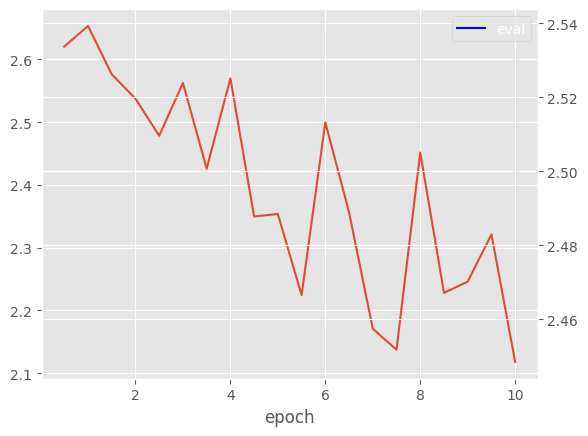

In [49]:
# example training
df_hist = data[-1]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()

<Axes: xlabel='epoch'>

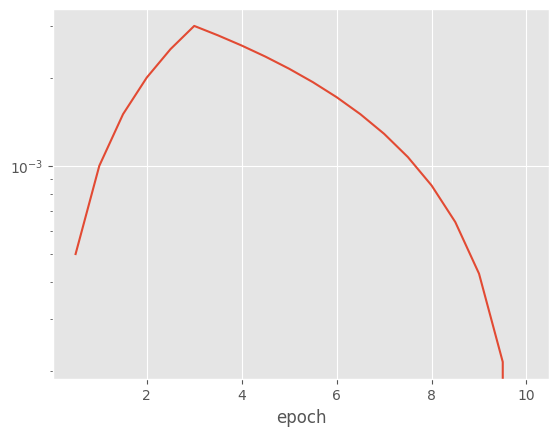

In [50]:
df_hist['learning_rate'].plot(logy=True)


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [51]:
df_res = pd.DataFrame(data)
df_res['len'] = df_res.content.str.len()
df_res = df_res[['before', 'after', 'title',  'len']].set_index('title')
df_res['improvement%'] = (df_res['before'] - df_res['after'])/ df_res['before']
df_res['improvement'] = (df_res['before'] - df_res['after'])
df_res['novel'] = df_res['before'] > 15
df_res['learnable'] = df_res['improvement%'] > 0.02

# We can measure the final score using learnable * novel
# df_res['BS'] = ~df_res['learnable'] | ~df_res['novel']
# Or just absolute perplexity improvement
df_res['BS'] = df_res['improvement'] < 1
df_res = df_res.sort_values('improvement%', ascending=False)
df_res

,before,after,len,improvement%,improvement,novel,learnable,BS
title,,,,,,,,
Lorem ipsum,22.067070,20.045456,19649,0.091612,2.021614,True,True,False
How to Catch an AI Liar,16.332514,14.918395,5464,0.086583,1.414119,True,True,False
weak to strong,12.332788,11.297444,5811,0.083951,1.035344,False,True,False
Gemini to Q*,50.878330,47.316181,42604,0.070013,3.562149,True,True,False
openai board ann,8.956921,8.373976,2991,0.065083,0.582945,False,True,True
buzzfeed foi fauci emails 2023,10.514380,9.999294,13640,0.048989,0.515086,False,True,True
statement by whitehouse on passing,8.469396,8.067771,1641,0.047421,0.401625,False,True,True
politics is the mind-killer,14.360717,13.831388,3158,0.036860,0.529329,False,True,True
LK-99-en,11.107546,10.768902,15432,0.030488,0.338644,False,True,True


In [52]:
print(df_res.to_markdown())

| title                                    |   before |    after |   len |   improvement% |   improvement | novel   | learnable   | BS    |
|:-----------------------------------------|---------:|---------:|------:|---------------:|--------------:|:--------|:------------|:------|
| Lorem ipsum                              | 22.0671  | 20.0455  | 19649 |      0.0916123 |     2.02161   | True    | True        | False |
| How to Catch an AI Liar                  | 16.3325  | 14.9184  |  5464 |      0.086583  |     1.41412   | True    | True        | False |
| weak to strong                           | 12.3328  | 11.2974  |  5811 |      0.0839505 |     1.03534   | False   | True        | False |
| Gemini to Q*                             | 50.8783  | 47.3162  | 42604 |      0.0700131 |     3.56215   | True    | True        | False |
| openai board ann                         |  8.95692 |  8.37398 |  2991 |      0.0650832 |     0.582945  | False   | True        | True  |
| buzzfeed foi fauci

# DEBUG

In [53]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [54]:
sample = samples[-1]
s = sample['content']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [55]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [56]:
gen(model, ds_train.with_format('pt')[0], tokenizer)